# DeepChem & Drug Formulation

This notebook demonstrates how to use DeepChem to predict key properties relevant to drug formulation.

**Goal:** To show how computational predictions can guide formulation scientists, reducing trial-and-error and accelerating development.

**Key Challenges in Drug Formulation Addressed:**
* **Solubility and Bioavailability:** Predicting aqueous solubility (logS) helps select solubility-enhancing techniques.
* **Distribution and Permeability:** Predicting lipophilicity (logD/logP) helps understand drug distribution. Blood-Brain Barrier (BBB) permeability predictions are crucial for CNS drugs.
* **Toxicity:** Predicting toxicity avoids harmful formulations early.
* **Stability/Other:** Predicting properties like hydration free energy informs stability and interactions.

## Setup and Imports

First, let's install the necessary packages and import the required libraries.

In [1]:
!pip install deepchem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 13.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw
import io, base64
from PIL import Image
from IPython.display import HTML, display, Image as IPImage
import warnings

import deepchem as dc
from deepchem.feat import CircularFingerprint
# Import the specific MolNet loaders needed
from deepchem.molnet import load_delaney, load_lipo, load_bbbp, load_tox21, load_freesolv
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, roc_auc_score
from deepchem.metrics import Metric
# Use DeepChem's implementation for consistency if needed
from deepchem.metrics import roc_auc_score as dc_roc_auc_score

# Set plotting styles
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# Suppress RDKit warnings for cleaner output (optional)
from rdkit import rdBase
rdBase.DisableLog('rdApp.warning')
warnings.filterwarnings('ignore', category=UserWarning, module='deepchem')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


## Helper Function: Molecule Visualization

We'll create a function to display molecules and their associated properties in a table format. This helps in visually inspecting the datasets.

In [3]:
def create_molecule_table(dataset, n=12, label_type='regression', task_name=None):
    """
    Create a HTML table with molecule structures and their properties

    Parameters:
    -----------
    dataset: DeepChem Dataset loaded with featurizer='Raw'
    n: Number of molecules to display
    label_type: 'regression' for continuous values, 'classification' for binary
    task_name: Name of the task (e.g., 'logS', 'logD', etc.)

    Returns:
    --------
    pandas.DataFrame with molecule images and properties, ready for HTML display
    """
    data = []
    # Ensure we don't try to display more molecules than available
    num_to_display = min(n, len(dataset))

    for i in range(num_to_display):
        smi = dataset.ids[i]
        mol = Chem.MolFromSmiles(smi)

        # Generate molecule image
        img_html = "Invalid SMILES" # Default value
        if mol is not None:
            try:
                img = Draw.MolToImage(mol, size=(200, 200))
                buf = io.BytesIO()
                img.save(buf, format="PNG")
                img_b64 = base64.b64encode(buf.getvalue()).decode('utf-8')
                img_html = f'<img src="data:image/png;base64,{img_b64}" width="200" height="200"/>'
            except Exception as e:
                 img_html = f"Image Generation Error: {e}"

        # Extract and format the label value
        label_val = dataset.y[i]
        label_str = "N/A" # Default value

        # Check if label_val is not empty and has expected structure
        if label_val is not None and hasattr(label_val, '__len__') and len(label_val) > 0:
             val_to_format = label_val[0]
             if label_type == 'regression':
                 # Format value to 3 decimal places
                 try:
                     label_str = f"{val_to_format:.3f}"
                 except (TypeError, ValueError):
                     label_str = str(val_to_format) # Fallback to string if formatting fails
             elif label_type == 'classification':
                 # Convert to integer for classification tasks
                 try:
                    label_str = "Active" if int(val_to_format) == 1 else "Inactive"
                 except (TypeError, ValueError):
                    label_str = str(val_to_format) # Fallback
             else:
                 label_str = str(val_to_format)
        elif label_val is not None: # Handle cases where y might be scalar or different format
             label_str = str(label_val)


        # Add to data list
        property_label = f"{task_name}: {label_str}" if task_name else label_str
        data.append([smi, img_html, property_label])

    # Create DataFrame
    df = pd.DataFrame(data, columns=["SMILES", "Structure", "Property"])
    return df

# 1. Solubility Prediction (ESOL Dataset)

**Formulation Challenge:** Low aqueous solubility limits oral bioavailability. Predicting solubility (logS) helps identify compounds needing enhancement (e.g., solid dispersions, nanoparticles).

**Dataset:** ESOL (Estimated SOLubility) - Contains ~1100 compounds with experimental logS values (logarithm of solubility in mol/L). More negative values mean lower solubility.

## 1.1 Load and Visualize ESOL Data

In [4]:
# Load ESOL dataset with raw SMILES for visualization
# Using load_delaney as specified in the proposal table
tasks_esol, datasets_esol_raw, transformers_esol = load_delaney(
    featurizer='Raw',
    splitter='random',
    reload=True
)
train_esol_raw, valid_esol_raw, test_esol_raw = datasets_esol_raw

# Print dataset information
print(f"ESOL Dataset Tasks: {tasks_esol}")
print(f"Number of training samples: {len(train_esol_raw)}")
print(f"Number of validation samples: {len(valid_esol_raw)}")
print(f"Number of test samples: {len(test_esol_raw)}")

ESOL Dataset Tasks: ['measured log solubility in mols per litre']
Number of training samples: 902
Number of validation samples: 113
Number of test samples: 113


In [ ]:
# Create summary statistics
y_all_esol = np.concatenate([train_esol_raw.y, valid_esol_raw.y, test_esol_raw.y])
print("\nSolubility (logS) Statistics:")
print(f"Mean: {np.mean(y_all_esol):.2f}")
print(f"Min: {np.min(y_all_esol):.2f}")
print(f"Max: {np.max(y_all_esol):.2f}")
print(f"Std Dev: {np.std(y_all_esol):.2f}")

# Visualize ESOL dataset distribution
plt.figure(figsize=(10, 6))
plt.hist(y_all_esol, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(y_all_esol), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(y_all_esol):.2f}')
plt.xlabel('logS (mol/L)')
plt.ylabel('Frequency')
plt.title('Distribution of Aqueous Solubility in ESOL Dataset')
plt.legend()
plt.show()

SMILES,Structure,Property
CCCCN(CC)c1c(cc(cc1N(=O)=O)C(F)(F)F)N(=O)=O,,logS: -1.172
CCCCCCC=C,,logS: -0.652
CC1CCCCC1NC(=O)Nc2ccccc2,,logS: -0.495
Cc1cccc(O)c1,,logS: 1.142
ClC(Cl)C(c1ccc(Cl)cc1)c2ccccc2Cl,,logS: -1.640
Cc3ccnc4N(C1CC1)c2ncccc2C(=O)Nc34,,logS: -0.056
Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O,,logS: -0.342
COC1=CC(=O)CC(C)C13Oc2c(Cl)c(OC)cc(OC)c2C3=O,,logS: -0.082
CCCSCCC,,logS: 0.235
O=C(Nc1ccccc1)Nc2ccccc2,,logS: -0.037

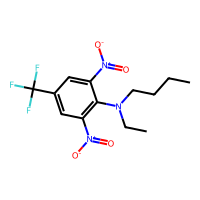
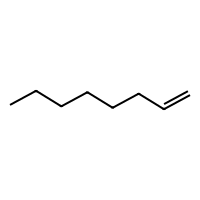
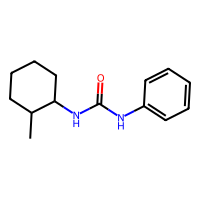
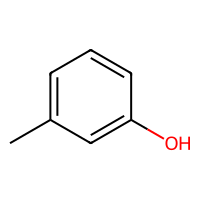
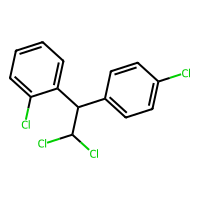
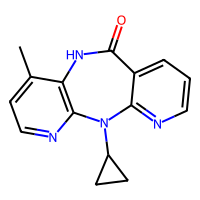
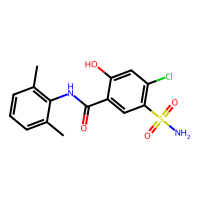
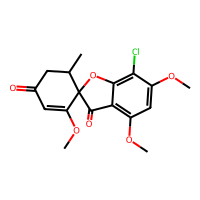
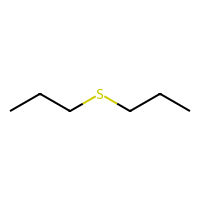
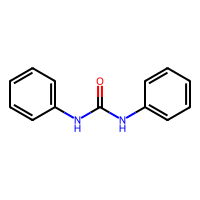

In [5]:
# Display sample molecules and their logS values
df_esol = create_molecule_table(train_esol_raw, n=10, label_type='regression', task_name='logS')
# Ensure display works in script context (might need adjustment outside notebook)
try:
    display(HTML(df_esol.to_html(escape=False, index=False)))
except NameError: # Fallback for non-IPython environments
    print(df_esol.to_string())

## 1.2 Train Solubility Prediction Model

We'll use ECFP (Extended-Connectivity Fingerprints) as features and train a Random Forest Regressor.

*Note: You might see a deprecation warning about `CircularFingerprint`. It still works, but newer featurizers could be explored.*

In [6]:
# Load ESOL dataset with ECFP fingerprints for modeling
# Note: Some molecules might fail featurization if they have invalid SMILES. DeepChem usually handles this.
featurizer_esol = CircularFingerprint(radius=2, size=1024)
tasks_esol, datasets_esol, transformers_esol = load_delaney(
    featurizer=featurizer_esol,
    splitter='random', # Consider 'scaffold' for more realistic evaluation
    transformers=[], # ESOL data is usually used without transformation
    reload=True
)
train_esol, valid_esol, test_esol = datasets_esol

# Train Random Forest regressor
rf_esol = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # Use n_jobs=-1 for parallelization
model_esol = dc.models.SklearnModel(rf_esol)
model_esol.fit(train_esol)

# Predict on test set
preds_esol = model_esol.predict(test_esol).flatten() # Ensure predictions are 1D
y_true_esol = test_esol.y.flatten() # Ensure true values are 1D

# Calculate metrics (RMSE)
mse_esol = mean_squared_error(y_true_esol, preds_esol)
rmse_esol = np.sqrt(mse_esol)
print(f"Test MSE: {mse_esol:.4f}")
print(f"Test RMSE: {rmse_esol:.4f}") # Expected RMSE ~0.6-0.9

Test MSE: 1.7561
Test RMSE: 1.3252


## 1.3 Visualize and Interpret ESOL Results

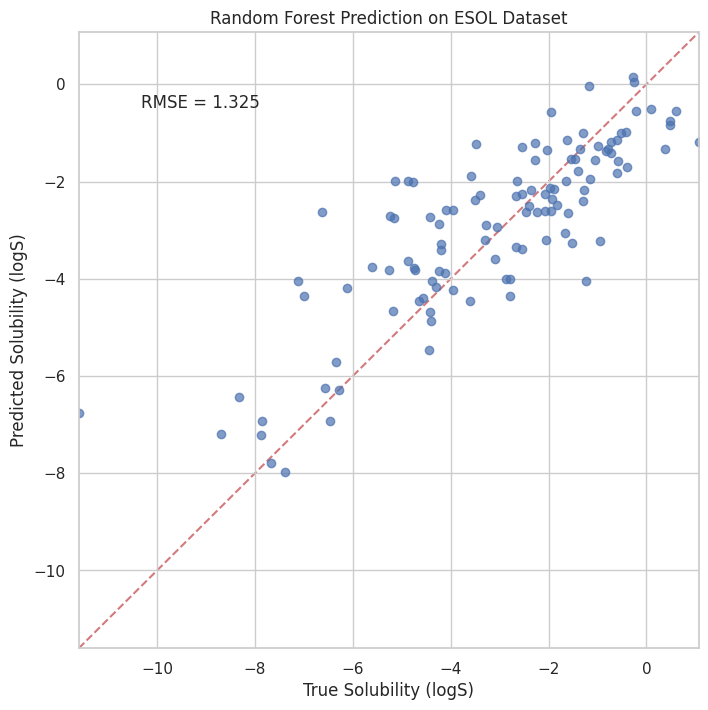

In [7]:
# Visualization of predictions vs. true values
plt.figure(figsize=(8, 8))
plt.scatter(y_true_esol, preds_esol, alpha=0.7)
plt.xlabel("True Solubility (logS)")
plt.ylabel("Predicted Solubility (logS)")
plt.title("Random Forest Prediction on ESOL Dataset")

# Add diagonal line y=x
lims = [min(np.min(y_true_esol), np.min(preds_esol)),
        max(np.max(y_true_esol), np.max(preds_esol))]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
plt.xlim(lims)
plt.ylim(lims)
plt.grid(True)
plt.text(lims[0]*0.9+lims[1]*0.1, lims[1]*0.9+lims[0]*0.1, f'RMSE = {rmse_esol:.3f}', ha='left', va='top')
plt.show()

**Interpretation:** The scatter plot shows the model's predictive accuracy. A good model has points close to the diagonal line. An RMSE around 0.7-0.9 is typical for this dataset. Predictions can flag compounds with potential solubility issues (e.g., predicted logS < -4), guiding formulators to consider techniques like salt formation, particle size reduction, or lipid-based formulations early on.

# 2. Lipophilicity Prediction (Lipophilicity Dataset)

**Formulation Challenge:** Lipophilicity (logD/logP) influences membrane permeability, distribution, protein binding, and formulation needs (e.g., solubilizers). Both very high and very low lipophilicity can pose challenges.

**Dataset:** Lipophilicity - Contains ~4200 compounds with experimental logD (distribution coefficient at pH 7.4). Higher values mean more lipophilic.

## 2.1 Load and Visualize Lipophilicity Data

In [8]:
# Load Lipophilicity dataset with raw SMILES for visualization
tasks_lipo, datasets_lipo_raw, transformers_lipo = load_lipo(
    featurizer='Raw',
    splitter='random',
    reload=True
)
train_lipo_raw, valid_lipo_raw, test_lipo_raw = datasets_lipo_raw

# Print dataset information
print(f"Lipophilicity Dataset Tasks: {tasks_lipo}")
print(f"Number of training samples: {len(train_lipo_raw)}")
print(f"Number of validation samples: {len(valid_lipo_raw)}")
print(f"Number of test samples: {len(test_lipo_raw)}")

Lipophilicity Dataset Tasks: ['exp']
Number of training samples: 3360
Number of validation samples: 420
Number of test samples: 420



Lipophilicity (logD @ pH 7.4) Statistics:
Mean: 0.01
Min: -3.04
Max: 1.93
Std Dev: 1.00


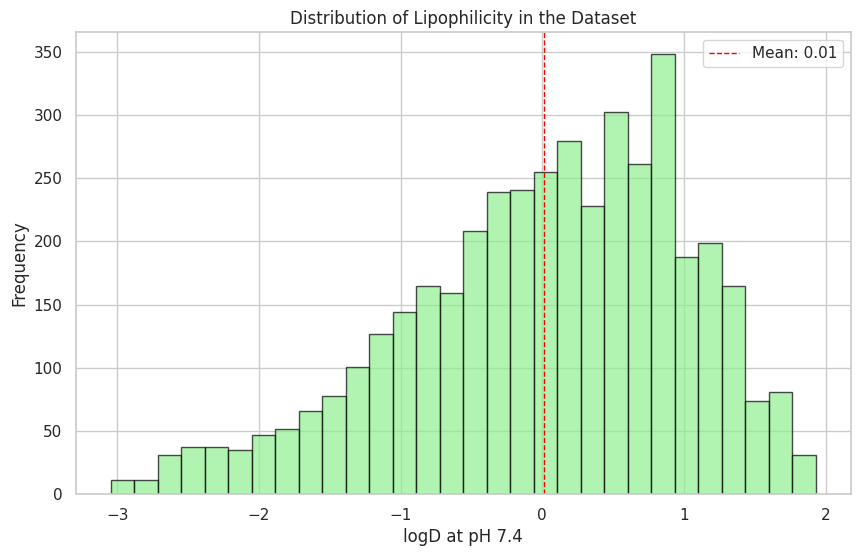

In [9]:
# Create summary statistics
y_all_lipo = np.concatenate([train_lipo_raw.y, valid_lipo_raw.y, test_lipo_raw.y])
print("\nLipophilicity (logD @ pH 7.4) Statistics:")
print(f"Mean: {np.mean(y_all_lipo):.2f}")
print(f"Min: {np.min(y_all_lipo):.2f}")
print(f"Max: {np.max(y_all_lipo):.2f}")
print(f"Std Dev: {np.std(y_all_lipo):.2f}")

# Visualize lipophilicity distribution
plt.figure(figsize=(10, 6))
plt.hist(y_all_lipo, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.axvline(np.mean(y_all_lipo), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(y_all_lipo):.2f}')
plt.xlabel('logD at pH 7.4')
plt.ylabel('Frequency')
plt.title('Distribution of Lipophilicity in the Dataset')
plt.legend()
plt.show()

SMILES,Structure,Property
COc1cc2nc(Nc3ccc(cc3)[C@@H](C)NC(=O)C)ncc2cc1c4ccncc4,,logD: 0.777
CO[C@@H]1C[C@@H](N(Cc2cc3c(Nc4cccc(Cl)c4F)ncnc3cc2OC)C1)C(=O)N,,logD: 0.761
NC(=O)c1nnn(c1N)c2ccccc2,,logD: -1.187
OC(=O)c1ccccc1CN2CCC(CN3CCC(CC3)Oc4ccc(Cl)c(Cl)c4)CC2,,logD: 0.255
CS(=O)(=O)c1ccc(cc1)c2cc(ccc2OCC(=O)O)C(F)(F)F,,logD: -2.522
CC(C)CN1C(=O)N(C)C(=O)c2c1nn(Cc3cccc4ccccc34)c2c5ccncc5,,logD: 1.764
CCOC(=O)Nc1ccc2Sc3ccccc3N(C(=O)CCN4CCOCC4)c2c1,,logD: 0.769
CC(C)C[C@H](NC(=O)N1CCOCC1)C(=O)N[C@@H](CCc2ccccc2)\C=C\S(=O)(=O)c3ccccc3,,logD: 1.018
CCC(CC)n1nc(C)c(C(=O)N[C@@H](C)C(C)(C)C)c1NS(=O)(=O)c2ccc(C)cc2,,logD: -0.242
CC1(C)Oc2ncnc(N)c2N=C1c3ccc(cc3)[C@@H]4CC[C@@H](CC(=O)O)CC4,,logD: -0.707

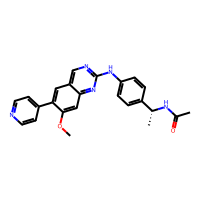
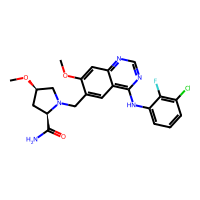
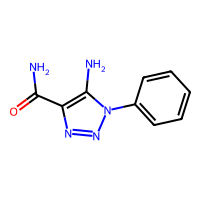
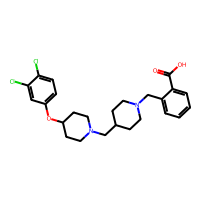
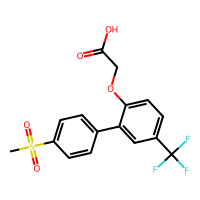
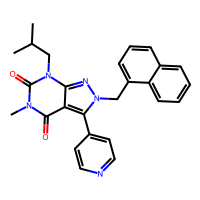
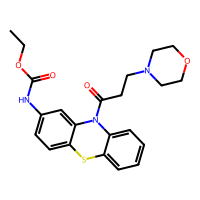
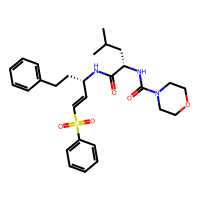
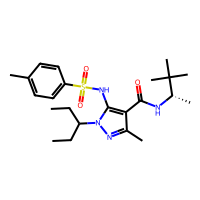
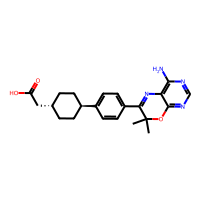

In [10]:
# Display sample molecules and their logD values
df_lipo = create_molecule_table(train_lipo_raw, n=10, label_type='regression', task_name='logD')
try:
    display(HTML(df_lipo.to_html(escape=False, index=False)))
except NameError:
    print(df_lipo.to_string())

## 2.2 Train Lipophilicity Prediction Model

In [11]:
# Load Lipophilicity dataset with ECFP fingerprints for modeling
featurizer_lipo = CircularFingerprint(radius=2, size=1024) # Using ECFP
tasks_lipo, datasets_lipo, transformers_lipo = load_lipo(
    featurizer=featurizer_lipo,
    splitter='random', # Consider 'scaffold'
    transformers=[], # Typically no transformation needed
    reload=True
)
train_lipo, valid_lipo, test_lipo = datasets_lipo

# Train Random Forest regressor
rf_lipo = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_lipo = dc.models.SklearnModel(rf_lipo)
model_lipo.fit(train_lipo)

# Predict on test set
preds_lipo = model_lipo.predict(test_lipo).flatten()
y_true_lipo = test_lipo.y.flatten()

# Calculate metrics (RMSE)
mse_lipo = mean_squared_error(y_true_lipo, preds_lipo)
rmse_lipo = np.sqrt(mse_lipo)
print(f"Test MSE: {mse_lipo:.4f}")
print(f"Test RMSE: {rmse_lipo:.4f}") # Expected RMSE ~0.6-0.8

Test MSE: 0.7550
Test RMSE: 0.8689


## 2.3 Visualize and Interpret Lipophilicity Results

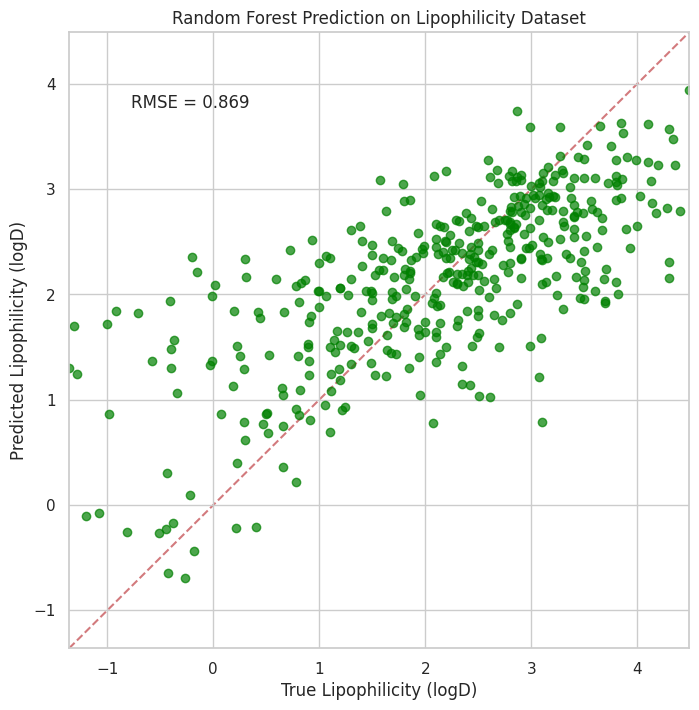

In [12]:
# Visualization of predictions vs. true values
plt.figure(figsize=(8, 8))
plt.scatter(y_true_lipo, preds_lipo, alpha=0.7, color='green')
plt.xlabel("True Lipophilicity (logD)")
plt.ylabel("Predicted Lipophilicity (logD)")
plt.title("Random Forest Prediction on Lipophilicity Dataset")

# Add diagonal line y=x
lims_lipo = [min(np.min(y_true_lipo), np.min(preds_lipo)),
             max(np.max(y_true_lipo), np.max(preds_lipo))]
plt.plot(lims_lipo, lims_lipo, 'r--', alpha=0.75, zorder=0)
plt.xlim(lims_lipo)
plt.ylim(lims_lipo)
plt.grid(True)
plt.text(lims_lipo[0]*0.9+lims_lipo[1]*0.1, lims_lipo[1]*0.9+lims_lipo[0]*0.1, f'RMSE = {rmse_lipo:.3f}', ha='left', va='top')
plt.show()

**Interpretation:** The model provides reasonable logD predictions (RMSE ~0.6-0.8).
* **High predicted logD (> 3):** Suggests potential solubility issues, high protein binding, maybe suitability for extended-release but risk of efflux. Formulation might need lipid-based systems.
* **Low predicted logD (< 0):** Suggests good solubility but potentially poor membrane permeability (requiring enhancers) or rapid clearance (needing modified release).

# 3. Blood-Brain Barrier Permeability (BBBP)

**Formulation Challenge:** Predicting BBB permeability is vital. CNS drugs *must* cross the BBB, while non-CNS drugs ideally *should not* to avoid side effects. This influences formulation strategy (e.g., needing delivery systems like nanoparticles if a CNS drug is predicted non-permeable).

**Dataset:** BBBP - Contains ~2000 compounds labeled 1 (permeable) or 0 (non-permeable). This is a classification task.

## 3.1 Load and Visualize BBBP Data

In [30]:
# Load BBBP dataset with raw SMILES for visualization
# Note: RDKit warnings about valence & featurization failures for some molecules are expected due to dataset issues.
tasks_bbbp, datasets_bbbp_raw, transformers_bbbp_raw = load_bbbp(
    featurizer='Raw',
    splitter='scaffold', # Scaffold split is recommended for BBBP
    reload=True
)
train_bbbp_raw, valid_bbbp_raw, test_bbbp_raw = datasets_bbbp_raw

# Print dataset information
print(f"BBBP Dataset Tasks: {tasks_bbbp}")
print(f"Number of training samples: {len(train_bbbp_raw)}")
print(f"Number of validation samples: {len(valid_bbbp_raw)}")
print(f"Number of test samples: {len(test_bbbp_raw)}")

BBBP Dataset Tasks: ['p_np']
Number of training samples: 1631
Number of validation samples: 204
Number of test samples: 204



BBBP Class Distribution:
BBB Permeable (1): 1560 (76.5%)
BBB Non-permeable (0): 479 (23.5%)


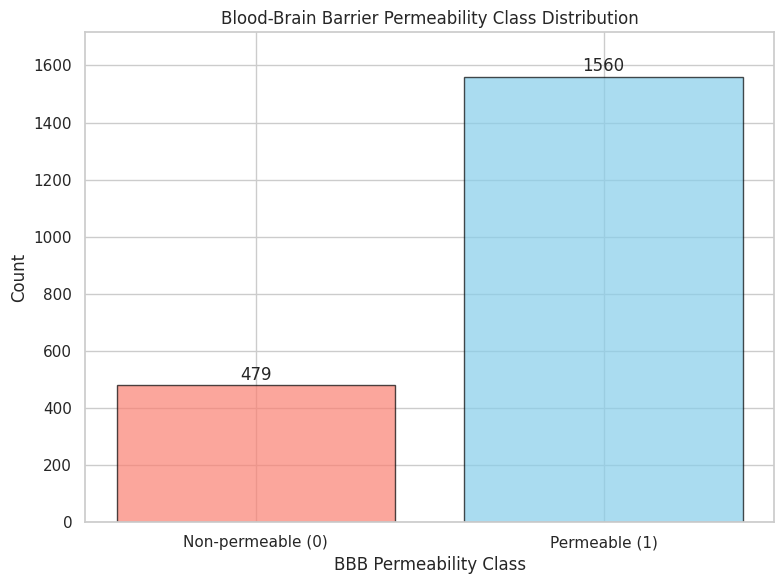

In [31]:
# Calculate class distribution
y_bbbp_all = np.concatenate([train_bbbp_raw.y, valid_bbbp_raw.y, test_bbbp_raw.y]).flatten()
permeable_count = np.sum(y_bbbp_all == 1)
nonpermeable_count = np.sum(y_bbbp_all == 0)
total_count = len(y_bbbp_all)

print("\nBBBP Class Distribution:")
print(f"BBB Permeable (1): {permeable_count} ({permeable_count/total_count*100:.1f}%)")
print(f"BBB Non-permeable (0): {nonpermeable_count} ({nonpermeable_count/total_count*100:.1f}%)")

# Visualize BBBP class distribution
plt.figure(figsize=(8, 6))
labels = ['Non-permeable (0)', 'Permeable (1)']
counts = [nonpermeable_count, permeable_count]
plt.bar(labels, counts, color=['salmon', 'skyblue'], alpha=0.7, edgecolor='black')
plt.xlabel('BBB Permeability Class')
plt.ylabel('Count')
plt.title('Blood-Brain Barrier Permeability Class Distribution')
for i, count in enumerate(counts):
    plt.text(i, count + 20, str(count), ha='center') # Adjust text position slightly
plt.ylim(0, max(counts)*1.1) # Adjust y-limit for better text visibility
plt.tight_layout()
plt.show()

SMILES,Structure,Property
C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,,BBB Permeability: Active
C[C@H](N)Cc1ccccc1,,BBB Permeability: Active
C[S](=O)(=O)c1ccc(cc1)[C@@H](O)[C@@H](CO)NC(=O)C(Cl)Cl,,BBB Permeability: Active
CC(N)COc1c(C)cccc1C,,BBB Permeability: Active
c1(ccccc1)CC,,BBB Permeability: Active
c1(c(cc(NC(CCC)=O)cc1)C(C)=O)OCC(CNC(C)C)O,,BBB Permeability: Active
CCN(CC)C(=O)Nc1ccc(OCC(O)CNC(C)(C)C)c(c1)C(C)=O,,BBB Permeability: Active
CC(=O)Nc1ccc(O)cc1,,BBB Permeability: Active
CC(=O)Oc1ccccc1C(O)=O,,BBB Permeability: Inactive
C[C@@](Cc1ccc(O)c(O)c1)(NN)C(O)=O,,BBB Permeability: Inactive

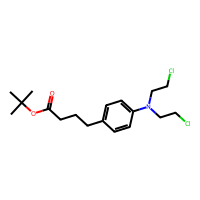
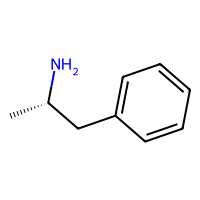
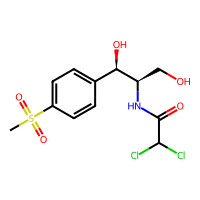
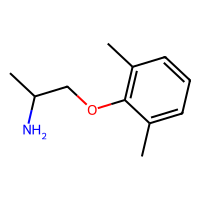
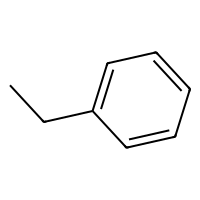
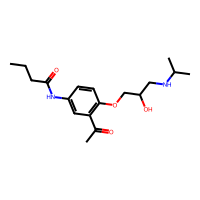
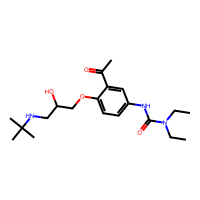
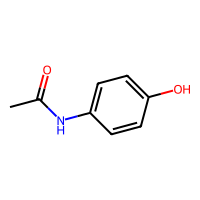
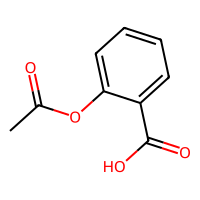
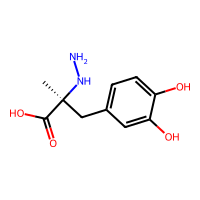
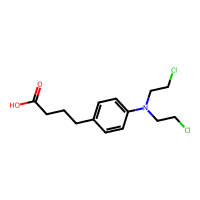
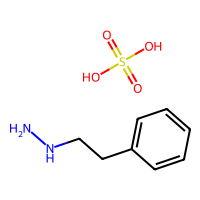

In [32]:
# Display sample molecules and their BBB permeability
# Note: Displaying from the training set as raw data is loaded that way
df_bbbp = create_molecule_table(train_bbbp_raw, n=12, label_type='classification', task_name='BBB Permeability')
try:
    display(HTML(df_bbbp.to_html(escape=False, index=False)))
except NameError:
    print(df_bbbp.to_string())

## 3.2 Train BBB Permeability Prediction Model

We'll again use ECFP features and a Random Forest Classifier. The evaluation metric will be ROC-AUC.

*Note: Some molecules in BBBP might fail featurization due to invalid structures.*

In [33]:
# Load BBBP dataset with ECFP fingerprints for modeling
# Note: Featurization warnings may appear again here.
featurizer_bbbp = CircularFingerprint(radius=2, size=1024)
tasks_bbbp, datasets_bbbp, transformers_bbbp = load_bbbp(
    featurizer=featurizer_bbbp,
    splitter='scaffold', # Use scaffold splitter
    transformers=[], # Usually no transformation
    reload=True
)
train_bbbp, valid_bbbp, test_bbbp = datasets_bbbp

# Train Random Forest classifier
rf_bbbp = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1) # Use balanced class weights
model_bbbp = dc.models.SklearnModel(rf_bbbp)
model_bbbp.fit(train_bbbp)

# Define ROC-AUC metric
# Use DeepChem's metric object for evaluation consistency
metric_roc_auc = Metric(dc_roc_auc_score, mode="classification")

# Evaluate on datasets
# Note: model.evaluate returns a dictionary of scores
train_scores = model_bbbp.evaluate(train_bbbp, [metric_roc_auc], [])
valid_scores = model_bbbp.evaluate(valid_bbbp, [metric_roc_auc], [])
test_scores = model_bbbp.evaluate(test_bbbp, [metric_roc_auc], [])

print("\nROC-AUC Scores:")
print(f"Training:   {train_scores[metric_roc_auc.name]:.4f}")
print(f"Validation: {valid_scores[metric_roc_auc.name]:.4f}")
print(f"Test:       {test_scores[metric_roc_auc.name]:.4f}") # Expected ROC-AUC ~0.7-0.8 for RF

# Prepare data for visualization in the next cell
y_true_bbbp_test = test_bbbp.y.flatten()
# Need probability predictions for ROC curve
y_pred_proba_bbbp_test = model_bbbp.model.predict_proba(test_bbbp.X)[:, 1] # Access sklearn model directly
# Need class predictions for confusion matrix
y_pred_class_bbbp_test = model_bbbp.predict(test_bbbp)
if y_pred_class_bbbp_test.ndim > 1:
    y_pred_class_bbbp_test = y_pred_class_bbbp_test[:,0].flatten()
else:
    y_pred_class_bbbp_test = y_pred_class_bbbp_test.flatten()

# Debug: Check shapes before confusion matrix cell
print(f"Shape check before confusion matrix cell: y_true={y_true_bbbp_test.shape}, y_pred={y_pred_class_bbbp_test.shape}")
# Debug: Check data types
print(f"Data type check: y_true={y_true_bbbp_test.dtype}, y_pred={y_pred_class_bbbp_test.dtype}")


ROC-AUC Scores:
Training:   0.9997
Validation: 0.9657
Test:       0.7029
Shape check before confusion matrix cell: y_true=(204,), y_pred=(204,)
Data type check: y_true=float64, y_pred=float64


## 3.3 Visualize and Interpret BBBP Results

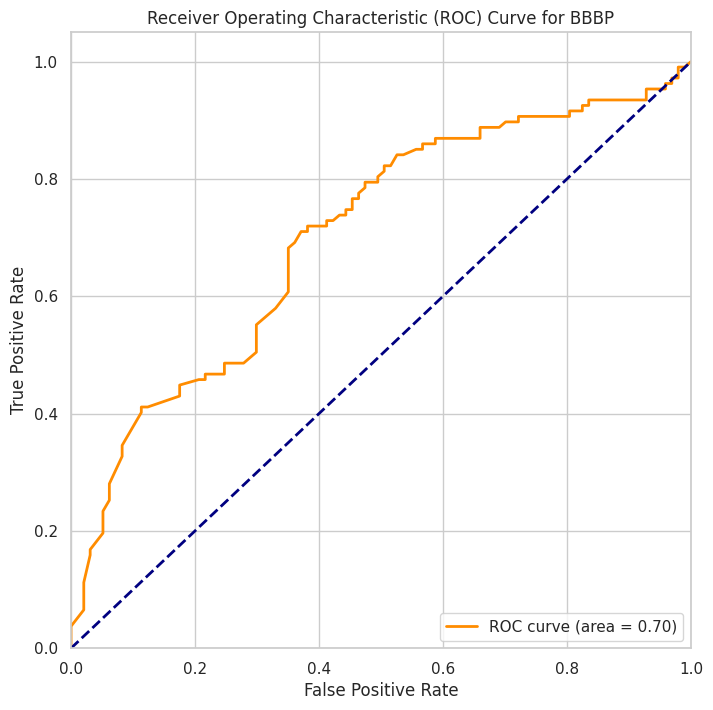

Type check before confusion matrix: y_true=int64, y_pred=int64


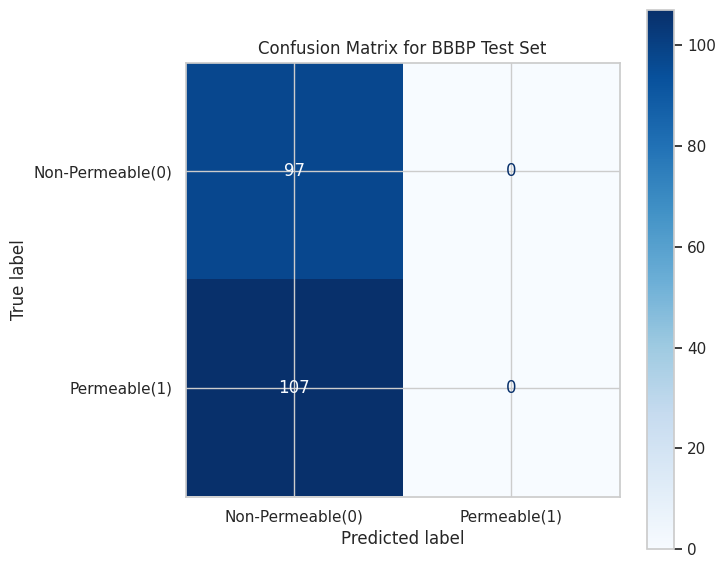

In [34]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Calculate ROC curve (using probabilities)
fpr, tpr, thresholds = roc_curve(y_true_bbbp_test, y_pred_proba_bbbp_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for BBBP')
plt.legend(loc="lower right")
plt.show()

# Calculate and display confusion matrix
# Ensure shapes match AND cast both to int to fix the ValueError
if y_true_bbbp_test.shape == y_pred_class_bbbp_test.shape:
    try:
        # <<< FIX: Convert both arrays to integer type >>>
        y_true_bbbp_test_int = y_true_bbbp_test.astype(int)
        y_pred_class_bbbp_test_int = y_pred_class_bbbp_test.astype(int)

        # Debug: Check types after conversion
        print(f"Type check before confusion matrix: y_true={y_true_bbbp_test_int.dtype}, y_pred={y_pred_class_bbbp_test_int.dtype}")

        # Calculate confusion matrix using integer arrays
        cm = confusion_matrix(y_true_bbbp_test_int, y_pred_class_bbbp_test_int)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Permeable(0)', 'Permeable(1)'])

        fig, ax = plt.subplots(figsize=(7, 7))
        disp.plot(cmap=plt.cm.Blues, ax=ax)
        plt.title('Confusion Matrix for BBBP Test Set')
        plt.show()
    except Exception as e:
        print(f"Error during confusion matrix calculation or display: {e}")
else:
    print(f"Error: Shape mismatch prevents confusion matrix generation.")
    print(f"y_true shape: {y_true_bbbp_test.shape}, y_pred shape: {y_pred_class_bbbp_test.shape}")

**Interpretation:**
* The ROC curve shows the trade-off between true positive and false positive rates. An AUC close to 1 indicates a good model.
* The confusion matrix shows the number of correct and incorrect predictions for each class.
* For a **CNS drug candidate**, a prediction of 'Permeable' (True Positive) supports standard formulation, while 'Non-permeable' (False Negative) suggests needing delivery enhancement.
* For a **non-CNS drug**, a prediction of 'Non-permeable' (True Negative) is desired. A 'Permeable' prediction (False Positive) might warrant monitoring for CNS side effects.

# 4. Toxicity Prediction (Tox21 Dataset)

**Formulation Challenge:** Ensuring the safety of the final drug product is paramount. Predicting potential toxicity early helps de-risk candidates and guides excipient selection (as excipients themselves should be non-toxic and not interact negatively).

**Dataset:** Tox21 - Contains qualitative toxicity data for ~8000 compounds against 12 different targets/pathways. This is a multi-task classification problem.

## 4.1 Load and Visualize Tox21 Data

In [35]:
# Load Tox21 dataset
# Note: RDKit warnings about valence (e.g., for Aluminum) & featurization failures are expected.
featurizer_tox = dc.feat.CircularFingerprint(size=1024)

tasks_tox, datasets_tox_raw, transformers_tox_raw = load_tox21(
    featurizer=featurizer_tox,
    splitter='scaffold', # Scaffold is standard for Tox21
    reload=True,
    # Load raw data first, apply transformer below
    transformers = []
)
train_tox_raw, valid_tox_raw, test_tox_raw = datasets_tox_raw

# Apply BalancingTransformer separately
# Initialize based on the *training* dataset only
balancer = dc.trans.BalancingTransformer(dataset=train_tox_raw)

train_tox = balancer.transform(train_tox_raw)
valid_tox = balancer.transform(valid_tox_raw)
test_tox = balancer.transform(test_tox_raw)

# Print dataset information
print(f"Tox21 Dataset Tasks ({len(tasks_tox)}): {tasks_tox}")
print(f"Number of training samples: {len(train_tox)}")
print(f"Number of validation samples: {len(valid_tox)}")
print(f"Number of test samples: {len(test_tox)}")

Tox21 Dataset Tasks (12): ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
Number of training samples: 6258
Number of validation samples: 782
Number of test samples: 783


In [36]:
# Examine missing data - Tox21 has many missing labels
# Calculate missing based on weights 'w' (0 means missing/ignore)
# Use the transformed training set (train_tox) for this calculation
missing_counts = np.sum(train_tox.w == 0, axis=0)
total_counts = len(train_tox)
present_percent = ( (total_counts - missing_counts) / total_counts) * 100

print("\nData Present Percentage per task (Training Set):")
for task, perc in zip(tasks_tox, present_percent):
    print(f"- {task}: {perc:.2f}% present")

# Visualize first few molecules (displaying SMILES only, as y is multi-task)
print("\nSample SMILES IDs from Tox21 Training Set:")
for i in range(min(10, len(train_tox))):
    print(f"- {train_tox.ids[i]}")


Data Present Percentage per task (Training Set):
- NR-AR: 93.00% present
- NR-AR-LBD: 87.89% present
- NR-AhR: 84.60% present
- NR-Aromatase: 76.43% present
- NR-ER: 81.14% present
- NR-ER-LBD: 89.98% present
- NR-PPAR-gamma: 84.56% present
- SR-ARE: 77.84% present
- SR-ATAD5: 91.55% present
- SR-HSE: 84.92% present
- SR-MMP: 76.32% present
- SR-p53: 87.71% present

Sample SMILES IDs from Tox21 Training Set:
- CC(O)(P(=O)(O)O)P(=O)(O)O
- CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
- OC[C@H](O)[C@@H](O)[C@H](O)CO
- CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]
- CC(C)COC(=O)C(C)C
- C=C(C)C(=O)OCCOC(=O)C(=C)C
- CCCCCCCCCCOCC(O)CN
- C#CCO
- CC(O)CC(C)(C)O
- CC(C)(C)CC(C)(C)N


## 4.2 Train Toxicity Prediction Model

We'll train a multi-task Random Forest Classifier using DeepChem's wrapper which trains one classifier per task.

*Note: Some molecules may fail featurization here as well.*

In [55]:
from sklearn.metrics import accuracy_score # Ensure accuracy_score is imported

# Train a separate RF classifier for each task implicitly via SklearnModel wrapper
rf_tox = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=None, n_jobs=-1)
# class_weight='balanced' is handled by BalancingTransformer via weights 'w' in train_tox
model_tox = dc.models.SklearnModel(rf_tox) # Handles multi-task fitting

# Fit the model on the BALANCED training data
print("Fitting model on balanced training data...")
model_tox.fit(train_tox)
print("Model fitting complete.")

# --- Evaluate Per Task Manually on the RAW test set ---
all_task_scores = {}
# Store data for visualization for ALL tasks
all_vis_data = {}

print("\nEvaluating performance per task manually on RAW test set (using Accuracy):")
# Diagnostic: Check total valid weights in raw test set
# print(f"Total valid weights per task in test_tox_raw: {np.sum(test_tox_raw.w == 1, axis=0)}") # Optional debug

for i, task in enumerate(tasks_tox):
    # Filter the *RAW* test set for valid samples for this task
    w_task_raw = test_tox_raw.w[:, i]
    valid_indices_raw = np.where(w_task_raw == 1)[0]

    if len(valid_indices_raw) > 0:
        # Select the valid subset from the RAW test data
        test_tox_task_filtered_raw = test_tox_raw.select(valid_indices_raw)
        try:
            # Get true labels from the filtered RAW subset
            y_true_task = test_tox_task_filtered_raw.y[:, i].astype(int) # Shape: (n_filtered,)

            # Predict classes using the main model (trained on balanced data)
            # Predict on the RAW filtered subset's features (X)
            # Output shape seems to be (n_tasks, n_filtered_samples, n_classes=2)
            all_preds = model_tox.predict(test_tox_task_filtered_raw)

            # Extract predictions for the current task i
            # Slice to get predictions for task i: shape (n_filtered_samples, n_classes=2)
            task_preds_scores = all_preds[i]

            # Determine predicted class using argmax along the class dimension (axis=1)
            y_pred_task = np.argmax(task_preds_scores, axis=1).astype(int) # Shape: (n_filtered,)

            # Calculate Accuracy score
            try:
                # Check shapes before calling accuracy_score
                if y_true_task.shape == y_pred_task.shape:
                    score = accuracy_score(y_true_task, y_pred_task)
                    # print(f"- Task '{task}': Accuracy = {score:.4f}") # Optional: Keep if you want per-task scores printed
                    all_task_scores[task] = score

                    # Store data needed for visualization for this task
                    all_vis_data[task] = {
                        'y_true': y_true_task,
                        'y_pred_class': y_pred_task
                    }
                else:
                    print(f"- Task '{task}': ERROR - Shape mismatch before accuracy score: y_true={y_true_task.shape}, y_pred={y_pred_task.shape}")
                    all_task_scores[task] = np.nan
            except ValueError as acc_err:
                print(f"- Task '{task}': ERROR calculating accuracy. {acc_err}")
                all_task_scores[task] = np.nan

        except Exception as e:
            print(f"- Task '{task}': Failed during prediction or data prep. Error: {e}")
            all_task_scores[task] = np.nan
    else:
        # print(f"- Task '{task}': No valid test samples in raw test set.") # Optional
        all_task_scores[task] = np.nan

# Calculate average score, ignoring NaNs
valid_scores = [s for s in all_task_scores.values() if not np.isnan(s)]
average_accuracy = np.mean(valid_scores) if valid_scores else 0.0
print(f"\nAverage Test Accuracy across evaluated Tox21 tasks: {average_accuracy:.4f}")

Fitting model on balanced training data...
Model fitting complete.

Evaluating performance per task manually on RAW test set (using Accuracy):

Average Test Accuracy across evaluated Tox21 tasks: 0.9067


## 4.3 Visualize and Interpret Tox21 Results (Single Task Example)


--- Confusion Matrix Visualization for All Valid Tasks ---


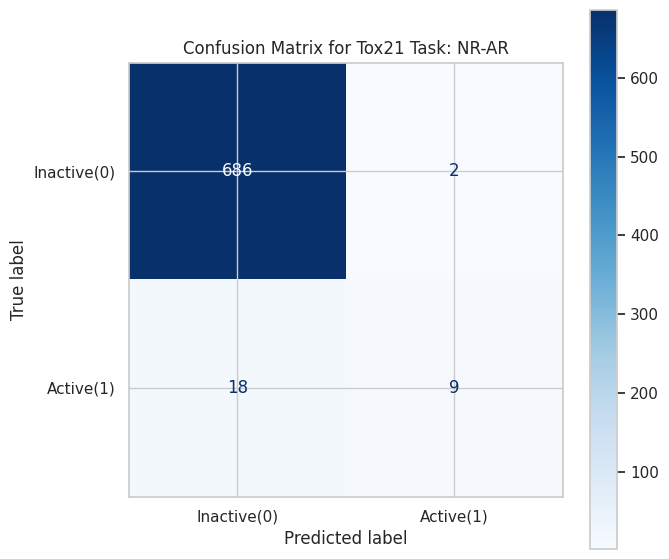

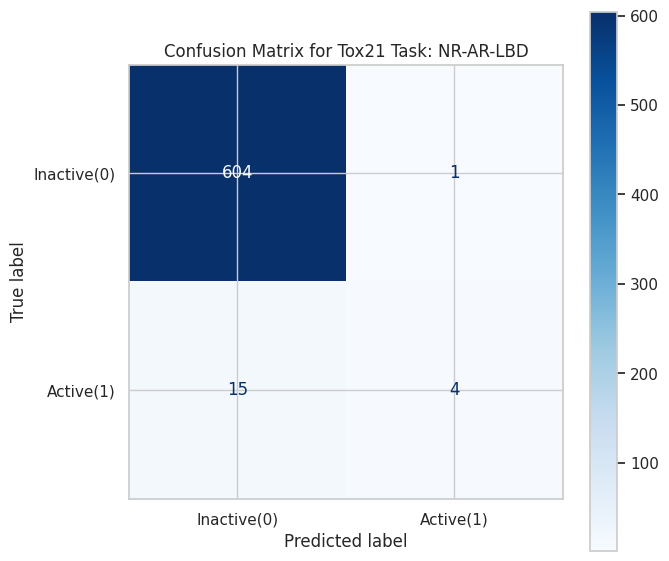

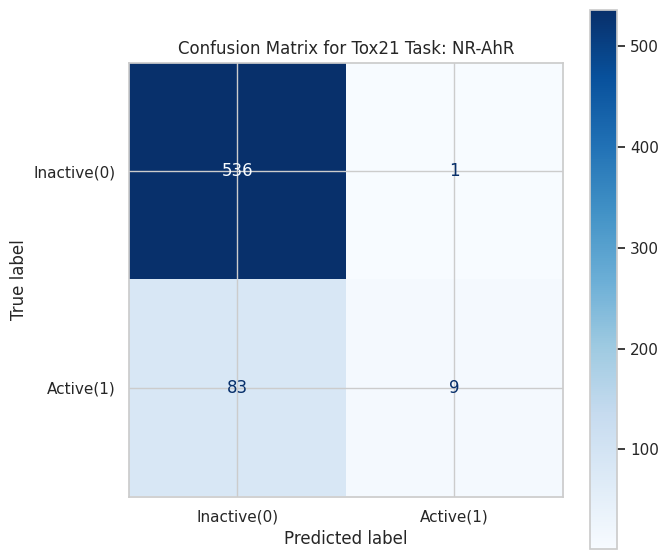

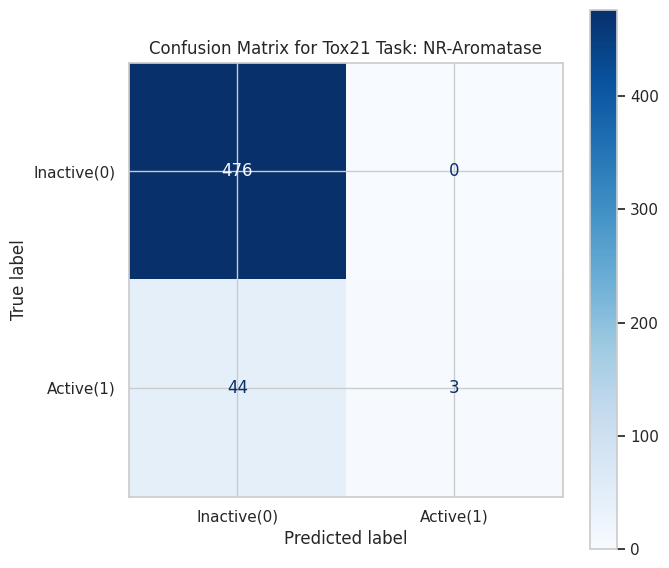

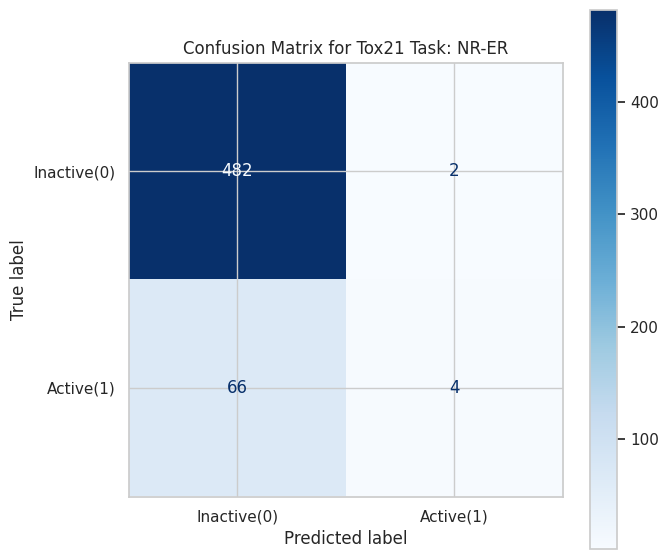

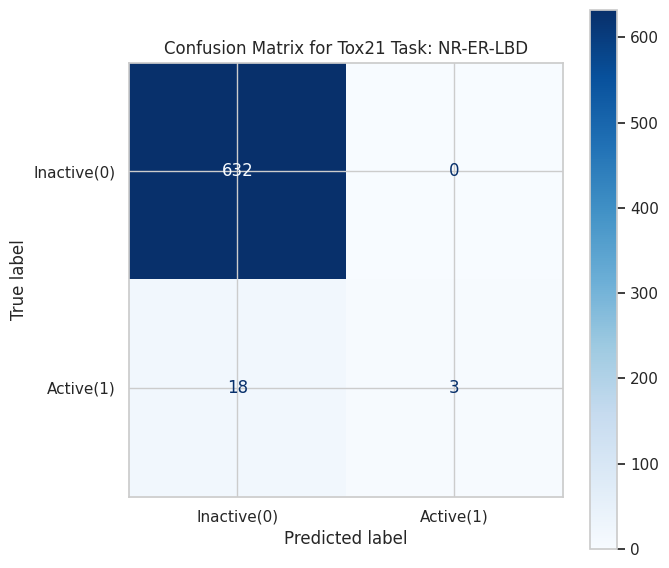

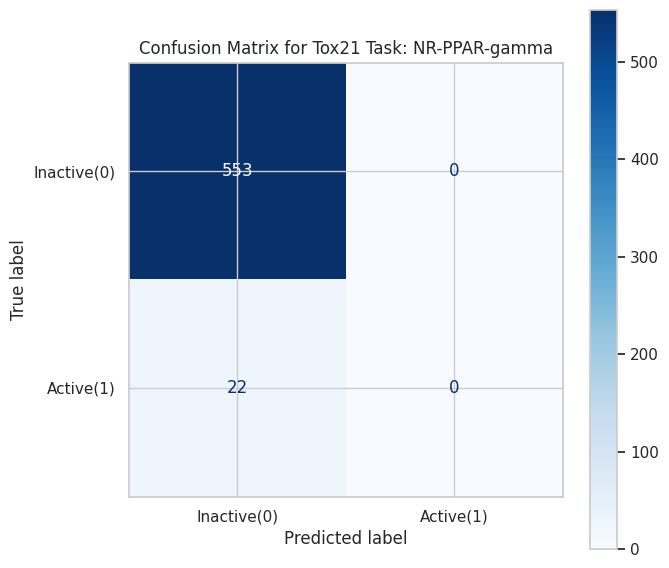

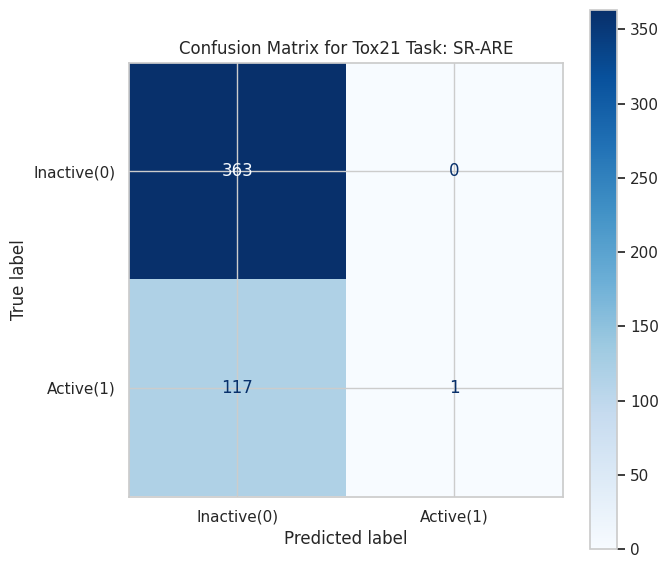

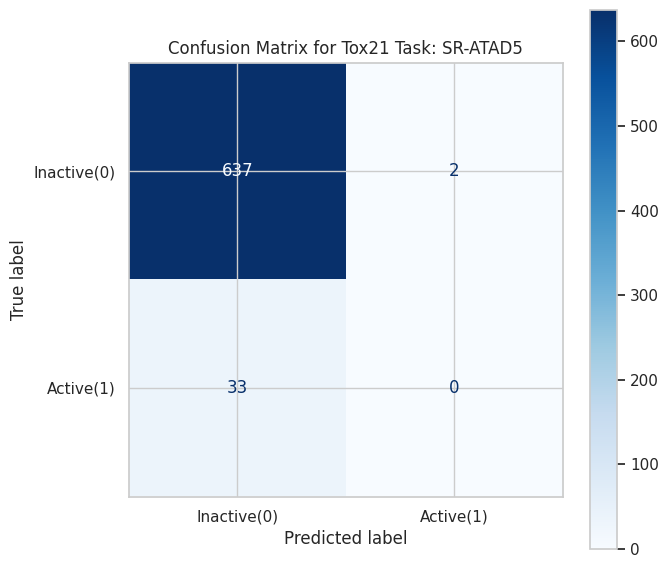

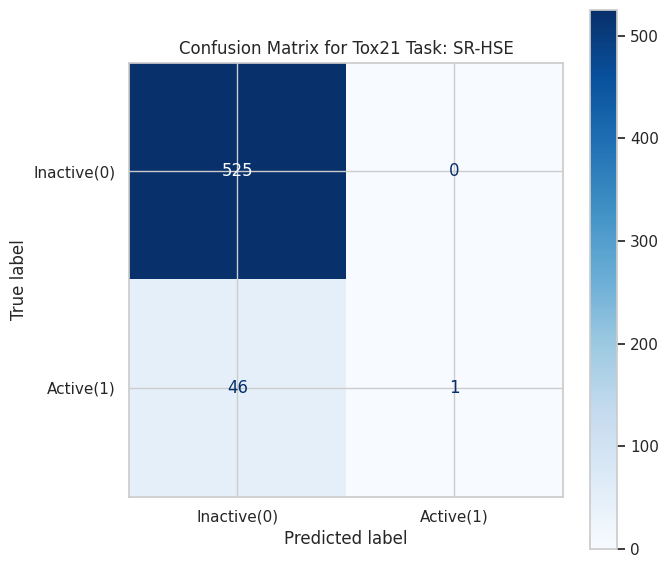

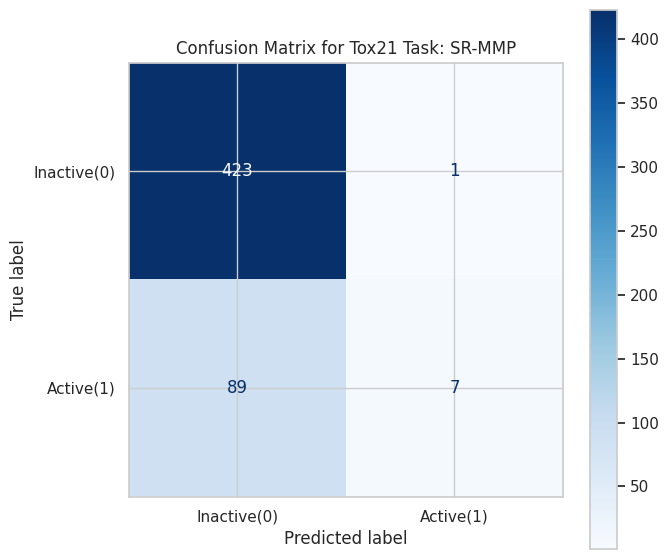

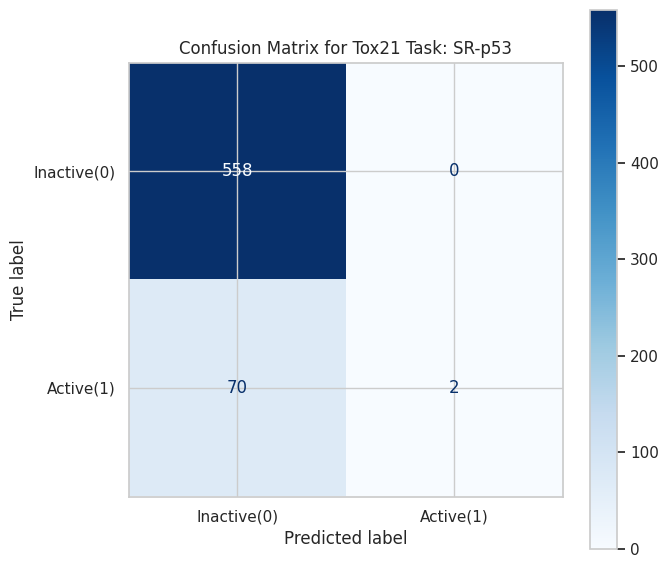


ROC curves cannot be generated (probabilities unavailable/unreliable).


In [56]:
print("\n--- Confusion Matrix Visualization for All Valid Tasks ---")

if all_vis_data: # Check if the dictionary is not empty
    for task_name, data in all_vis_data.items():
        y_true = data['y_true']
        y_pred_class = data['y_pred_class']

        # Display confusion matrix for the current task
        # Check shapes before plotting
        if y_true.shape == y_pred_class.shape:
            try:
                cm_tox = confusion_matrix(y_true, y_pred_class)
                disp_tox = ConfusionMatrixDisplay(confusion_matrix=cm_tox, display_labels=['Inactive(0)', 'Active(1)'])

                # Create a new figure for each plot
                fig, ax = plt.subplots(figsize=(7, 7))
                disp_tox.plot(cmap=plt.cm.Blues, ax=ax)
                plt.title(f'Confusion Matrix for Tox21 Task: {task_name}')
                plt.show() # Display the plot for this task
            except Exception as e:
                print(f"Error displaying confusion matrix for task '{task_name}': {e}")
        else:
            print(f"Shape mismatch for confusion matrix for task '{task_name}': y_true={y_true.shape}, y_pred_class={y_pred_class.shape}")

    # ROC curve plot removed as probabilities were not reliably obtained.
    print(f"\nROC curves cannot be generated (probabilities unavailable/unreliable).")

else:
    print("Skipping visualization as no task data was successfully generated in the previous step.")

**Interpretation (Single Task Example):**
* The confusion matrix and optional ROC curve show performance for the selected toxicity assay.
* Ideally, safe compounds should be predicted 'Inactive' (True Negatives).
* Compounds predicted 'Active' (True Positives or False Positives) warrant further investigation or de-prioritization.
* **Formulation Context:** Consistently predicting 'Inactive' across multiple relevant toxicity endpoints increases confidence in a compound's safety profile. Excipients must also be non-toxic and compatible.

# 5. Hydration Free Energy Prediction (FreeSolv Dataset)

**Formulation Challenge:** Hydration free energy relates to how favorably a molecule interacts with water. It's fundamental to solubility and partitioning behavior, impacting dissolution rate, membrane crossing, and interactions within aqueous formulations.

**Dataset:** FreeSolv - Contains experimental and calculated hydration free energy values (kcal/mol) for ~640 small molecules. This is a regression task.

## 5.1 Load and Visualize FreeSolv Data

In [21]:
# Load FreeSolv dataset
tasks_fs, datasets_fs_raw, transformers_fs_raw = load_freesolv(
    featurizer='Raw',
    splitter='random',
    reload=True
)
train_fs_raw, valid_fs_raw, test_fs_raw = datasets_fs_raw

# Print dataset information
print(f"FreeSolv Dataset Tasks: {tasks_fs}")
print(f"Number of training samples: {len(train_fs_raw)}")
print(f"Number of validation samples: {len(valid_fs_raw)}")
print(f"Number of test samples: {len(test_fs_raw)}")

FreeSolv Dataset Tasks: ['y']
Number of training samples: 513
Number of validation samples: 64
Number of test samples: 65



Hydration Free Energy (kcal/mol) Statistics:
Mean: 0.03
Min: -5.52
Max: 1.88
Std Dev: 0.98


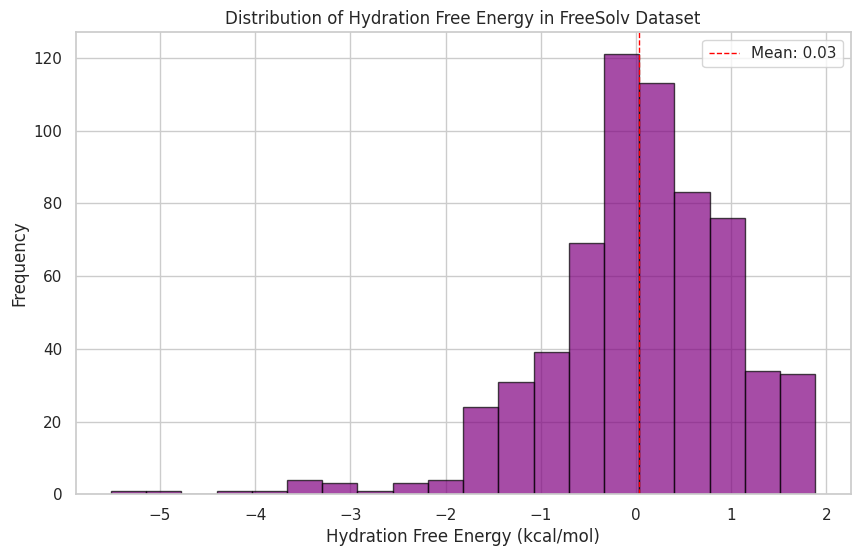

In [22]:
# Create summary statistics
y_all_fs = np.concatenate([train_fs_raw.y, valid_fs_raw.y, test_fs_raw.y])
print("\nHydration Free Energy (kcal/mol) Statistics:")
print(f"Mean: {np.mean(y_all_fs):.2f}")
print(f"Min: {np.min(y_all_fs):.2f}")
print(f"Max: {np.max(y_all_fs):.2f}")
print(f"Std Dev: {np.std(y_all_fs):.2f}")

# Visualize FreeSolv dataset distribution
plt.figure(figsize=(10, 6))
plt.hist(y_all_fs, bins=20, alpha=0.7, color='purple', edgecolor='black')
plt.axvline(np.mean(y_all_fs), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(y_all_fs):.2f}')
plt.xlabel('Hydration Free Energy (kcal/mol)')
plt.ylabel('Frequency')
plt.title('Distribution of Hydration Free Energy in FreeSolv Dataset')
plt.legend()
plt.show()

SMILES,Structure,Property
CO,,Hydration Free Energy (kcal/mol): -0.301
CN1CCNCC1,,Hydration Free Energy (kcal/mol): -0.984
Cc1ccc(c(c1)C)C,,Hydration Free Energy (kcal/mol): 0.785
C1CCCCC1,,Hydration Free Energy (kcal/mol): 1.320
CCCOC,,Hydration Free Energy (kcal/mol): 0.580
CCC(=O)OC,,Hydration Free Energy (kcal/mol): 0.255
CCCCCCBr,,Hydration Free Energy (kcal/mol): 1.051
c1ccc(cc1)C(=O)N,,Hydration Free Energy (kcal/mol): -1.811
c1ccc(c(c1)[N+](=O)[O-])O,,Hydration Free Energy (kcal/mol): -0.167
Cc1cccc(c1C)O,,Hydration Free Energy (kcal/mol): -0.572

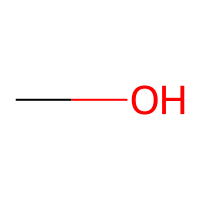
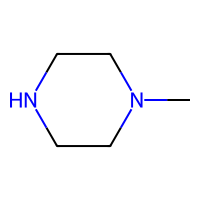
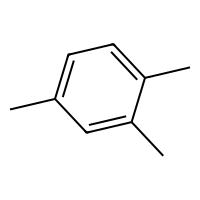
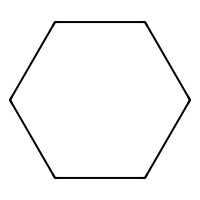
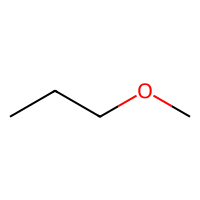
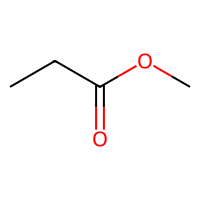
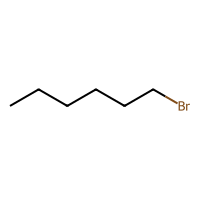
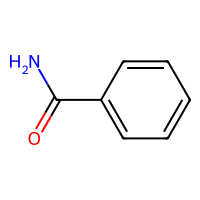
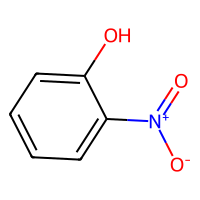
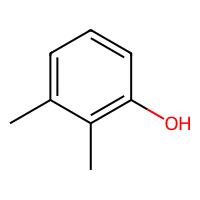

In [23]:
# Display sample molecules and their hydration free energy values
df_fs = create_molecule_table(train_fs_raw, n=10, label_type='regression', task_name='Hydration Free Energy (kcal/mol)')
try:
    display(HTML(df_fs.to_html(escape=False, index=False)))
except NameError:
    print(df_fs.to_string())

## 5.2 Train Hydration Free Energy Prediction Model

In [24]:
# Load FreeSolv dataset with ECFP fingerprints for modeling
featurizer_fs = CircularFingerprint(radius=2, size=1024)
tasks_fs, datasets_fs, transformers_fs = load_freesolv(
    featurizer=featurizer_fs,
    splitter='random', # Consider 'scaffold'
    transformers=[], # No transformation typically needed
    reload=True
)
train_fs, valid_fs, test_fs = datasets_fs

# Train Random Forest regressor
rf_fs = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_fs = dc.models.SklearnModel(rf_fs)
model_fs.fit(train_fs)

# Predict on test set
preds_fs = model_fs.predict(test_fs).flatten()
y_true_fs = test_fs.y.flatten()

# Calculate metrics (RMSE)
mse_fs = mean_squared_error(y_true_fs, preds_fs)
rmse_fs = np.sqrt(mse_fs)
print(f"Test MSE: {mse_fs:.4f}")
print(f"Test RMSE: {rmse_fs:.4f}") # FreeSolv typically yields lower RMSEs than ESOL

Test MSE: 0.3868
Test RMSE: 0.6219


## 5.3 Visualize and Interpret FreeSolv Results

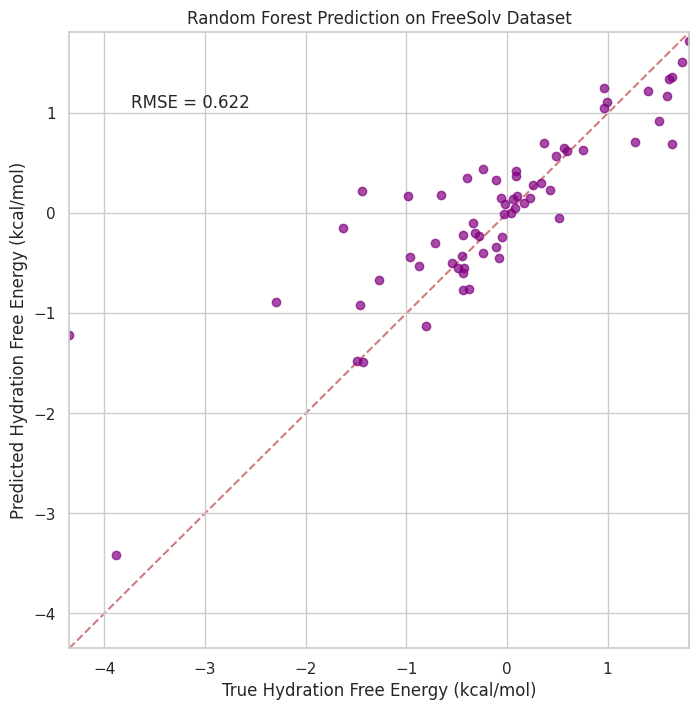

In [25]:
# Visualization of predictions vs. true values
plt.figure(figsize=(8, 8))
plt.scatter(y_true_fs, preds_fs, alpha=0.7, color='purple')
plt.xlabel("True Hydration Free Energy (kcal/mol)")
plt.ylabel("Predicted Hydration Free Energy (kcal/mol)")
plt.title("Random Forest Prediction on FreeSolv Dataset")

# Add diagonal line y=x
lims_fs = [min(np.min(y_true_fs), np.min(preds_fs)),
           max(np.max(y_true_fs), np.max(preds_fs))]
plt.plot(lims_fs, lims_fs, 'r--', alpha=0.75, zorder=0)
plt.xlim(lims_fs)
plt.ylim(lims_fs)
plt.grid(True)
plt.text(lims_fs[0]*0.9+lims_fs[1]*0.1, lims_fs[1]*0.9+lims_fs[0]*0.1, f'RMSE = {rmse_fs:.3f}', ha='left', va='top')
plt.show()

**Interpretation:** The model predicts hydration free energy. More negative values indicate more favorable interaction with water (hydrophilicity). This property is closely related to solubility and partitioning. Accurate predictions can help refine understanding of a compound's behavior in aqueous environments, complementing direct solubility (logS) predictions and aiding in the selection of appropriate formulation strategies (e.g., assessing the need for co-solvents or surfactants).

# 6. Custom Dataset Example (B3DB - Quantitative BBB)

This section demonstrates loading and preparing a custom dataset, using a small sample from B3DB (a quantitative Blood-Brain Barrier dataset with logBB values) as an example. In a real scenario, you would load this from a file (e.g., CSV, TSV).

**Formulation Context:** Quantitative logBB provides finer-grained information than binary BBBP classification, potentially allowing more precise tuning of formulations for CNS delivery or avoidance.

In [26]:
# --- Create Sample B3DB Data (Replace with file loading in practice) ---
# Example from corrected JSON / proposal pseudocode
sample_data_b3db = [
    {"SMILES": "CCO", "logBB": -0.82},  # Ethanol
    {"SMILES": "CN1C=NC2=C1C(=O)N(C(=O)N2C)C", "logBB": -0.28},  # Caffeine
    {"SMILES": "CC1=C(C=C(C=C1)NS(=O)(=O)C)C(=O)O", "logBB": -1.78},  # Sulfamethoxazole
    {"SMILES": "C1=CC=C(C=C1)N2C(=O)C3=C(C2=O)C=CC=C3", "logBB": 0.37},  # Phenytoin
    {"SMILES": "CC(C)NCC(COC1=CC=C(C=C1)CCOC)O", "logBB": 0.14},  # Metoprolol
    {"SMILES": "CCCC1=NN(C2=C1N=C(NC2=O)C3=C(C=CC(=C3)S(=O)(=O)N4CCN(CC4)C)OC)C", "logBB": -0.56},  # Sildenafil
]
df_b3db = pd.DataFrame(sample_data_b3db)
print("Sample Custom Dataset (B3DB):")
print(df_b3db)

Sample Custom Dataset (B3DB):
                                              SMILES  logBB
0                                                CCO  -0.82
1                       CN1C=NC2=C1C(=O)N(C(=O)N2C)C  -0.28
2                  CC1=C(C=C(C=C1)NS(=O)(=O)C)C(=O)O  -1.78
3              C1=CC=C(C=C1)N2C(=O)C3=C(C2=O)C=CC=C3   0.37
4                     CC(C)NCC(COC1=CC=C(C=C1)CCOC)O   0.14
5  CCCC1=NN(C2=C1N=C(NC2=O)C3=C(C=CC(=C3)S(=O)(=O...  -0.56


In [27]:
# --- Prepare Data for DeepChem ---
smiles_list_b3db = df_b3db["SMILES"].tolist()
logbb_values_b3db = df_b3db["logBB"].values

# Visualize molecules with logBB values
print("\nVisualizing Sample Molecules:")
mols_b3db = [Chem.MolFromSmiles(smi) for smi in smiles_list_b3db]
valid_mols_legends = [(m, f"logBB = {val:.2f}") for m, val in zip(mols_b3db, logbb_values_b3db) if m is not None]
valid_mols = [item[0] for item in valid_mols_legends]
valid_legends = [item[1] for item in valid_mols_legends]

if valid_mols:
    img_b3db = Draw.MolsToGridImage(valid_mols, molsPerRow=3, subImgSize=(200, 200), legends=valid_legends)
    # Save image to a buffer to display using IPython.display.Image
    buf = io.BytesIO()
    # Draw.MolsToGridImage returns a PIL Image if returnPNG=False (default)
    try: # Ensure img_b3db is a PIL Image
        img_b3db.save(buf, format='png')
        buf.seek(0)
        display(IPImage(data=buf.read())) # Use IPython display
    except AttributeError:
        print("Could not display image (MolsToGridImage might have failed).")

else:
    print("No valid molecules to display.")


Visualizing Sample Molecules:
Could not display image (MolsToGridImage might have failed).


In [28]:
# --- Featurize and Create DeepChem Dataset ---
featurizer_b3db = CircularFingerprint(size=1024)
X_b3db = featurizer_b3db.featurize(smiles_list_b3db)

# Create dataset (handle potential featurization failures if any SMILES were invalid)
# Filter out instances where featurization might have failed (returns None or incorrect shape)
# For ECFP, it usually returns a vector of zeros for invalid SMILES
valid_indices_b3db = [i for i, x in enumerate(X_b3db) if x is not None and isinstance(x, np.ndarray) and x.shape == (1024,)]

if len(valid_indices_b3db) < len(smiles_list_b3db):
    print(f"Warning: Could only featurize {len(valid_indices_b3db)} out of {len(smiles_list_b3db)} molecules.")

X_b3db_valid = np.vstack([X_b3db[i] for i in valid_indices_b3db]) if valid_indices_b3db else np.empty((0, 1024))
y_b3db_valid = logbb_values_b3db[valid_indices_b3db].reshape(-1, 1)
ids_b3db_valid = [smiles_list_b3db[i] for i in valid_indices_b3db]

if len(X_b3db_valid) > 0:
    custom_dataset_b3db = dc.data.NumpyDataset(X=X_b3db_valid, y=y_b3db_valid, ids=ids_b3db_valid)
    print(f"\nCustom DeepChem Dataset created with {len(custom_dataset_b3db)} molecules.")
    print(f"Feature shape: {custom_dataset_b3db.X.shape}")
else:
    print("\nCould not create custom dataset (no valid molecules featurized).")


Custom DeepChem Dataset created with 6 molecules.
Feature shape: (6, 1024)


In [29]:
# --- Model Training (Conceptual) ---
print("\nNote: With only a few molecules, we won't train a meaningful model here.")
print("In a real scenario with hundreds/thousands of compounds, you would:")
print("1. Split the custom_dataset into train/validation/test sets (e.g., using RandomSplitter or ScaffoldSplitter).")
print("2. Train a regression model (e.g., RandomForestRegressor, GraphConvModel for regression).")
print("3. Evaluate performance using metrics like RMSE.")
print("4. Use the trained model to predict logBB for new compounds to guide formulation.")

# Example placeholder for training step
if 'custom_dataset_b3db' in locals() and len(custom_dataset_b3db) > 3: # Need enough data to split
   try:
       splitter_b3db = dc.splits.RandomSplitter()
       train_b3db_custom, valid_b3db_custom, test_b3db_custom = splitter_b3db.train_valid_test_split(custom_dataset_b3db, frac_train=0.6, frac_valid=0.2, frac_test=0.2) # Need explicit fractions for small dataset
       if len(train_b3db_custom) > 0 and len(test_b3db_custom) > 0:
           model_b3db_custom = dc.models.SklearnModel(RandomForestRegressor(n_estimators=10)) # Few estimators for demo
           model_b3db_custom.fit(train_b3db_custom)
           # Use mean_squared_error directly for RMSE calculation
           rmse_metric = Metric(mean_squared_error, mode='regression')
           scores = model_b3db_custom.evaluate(test_b3db_custom, [rmse_metric], [])
           # Check if metric calculation was successful
           if rmse_metric.name in scores:
               rmse_b3db = np.sqrt(scores[rmse_metric.name])
               print(f"Example Test RMSE (placeholder): {rmse_b3db:.3f}")
           else:
               print("Could not calculate RMSE score.")
       else:
           print("Not enough data in train/test splits for placeholder training.")
   except Exception as e:
       print(f"Error during placeholder training/evaluation: {e}")
else:
    print("Skipping placeholder training due to insufficient data.")


Note: With only a few molecules, we won't train a meaningful model here.
In a real scenario with hundreds/thousands of compounds, you would:
1. Split the custom_dataset into train/validation/test sets (e.g., using RandomSplitter or ScaffoldSplitter).
2. Train a regression model (e.g., RandomForestRegressor, GraphConvModel for regression).
3. Evaluate performance using metrics like RMSE.
4. Use the trained model to predict logBB for new compounds to guide formulation.
Example Test RMSE (placeholder): 1.167


# 7. Conclusion & Integrated Formulation Strategy

This notebook demonstrated using DeepChem to predict key properties influencing drug formulation:
1.  **Aqueous Solubility (ESOL):** Identifying needs for solubility enhancement.
2.  **Lipophilicity (Lipophilicity):** Understanding distribution and permeability characteristics.
3.  **BBB Permeability (BBBP):** Assessing suitability for CNS targets or potential side effects.
4.  **Toxicity (Tox21):** Early safety assessment.
5.  **Hydration Free Energy (FreeSolv):** Refining understanding of aqueous interactions.

**Integrated Approach:**
By combining these predictions, formulators can build a more complete profile of a drug candidate early on:
* **Identify Challenges:** Is the drug poorly soluble? Highly lipophilic? Potentially toxic? Likely to cross the BBB unexpectedly?
* **Select Excipients & Technologies:** Predictions guide the choice of solubilizers, stabilizers, permeation enhancers, and formulation types (e.g., solid dispersions, lipid systems, nanoparticles).
* **Reduce Experiments:** Computational screening focuses lab work on the most promising formulation strategies, saving time and resources.
* **Optimize Delivery:** Tailor formulations for specific needs (e.g., ensuring CNS penetration or designing extended-release for rapidly cleared drugs).

While *in silico* models don't replace experiments, they provide valuable guidance, enabling more rational, efficient, and successful drug formulation development. DeepChem provides a powerful platform for building and applying these predictive models.

**Future Directions:** Could include predicting drug-excipient compatibility, stability, dissolution profiles, or integrating predictions into PBPK models.

*End of Tutorial Draft*